In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [5]:
#Define callback that will take the current epoch and use it to set the current learning rate
#1e-8 = 10**-8
#e is not epsilon but is 10 to the power of something!
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [6]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

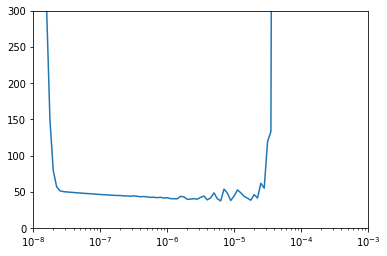

In [8]:
#Plot graph with log scaling 
plt.semilogx(history.history['lr'],history.history['loss'])
# [xmin, xmax, ymin, ymax]
plt.axis([1e-8, 1e-3, 0, 300])

#Looking at the graph, it seems that the lowest point is at 7 x 10**-6.   This can be written as 7e-6

(1e-08, 0.001, 0.0, 300.0)

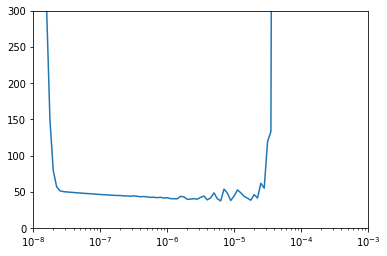

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
#Plot graph with log scaling 
plt.semilogx(lrs,history.history['loss'])
# [xmin, xmax, ymin, ymax]
plt.axis([1e-8, 1e-3, 0, 300])


In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

[37.63072204589844, 37.32371139526367, 37.88732147216797, 38.42526626586914, 36.50642013549805, 36.803550720214844, 38.167747497558594, 35.09067153930664, 34.581363677978516, 36.99227523803711, 37.20589828491211, 39.588714599609375, 38.47065353393555, 35.72966003417969, 35.81498336791992, 37.76579284667969, 39.288089752197266, 39.1092643737793, 36.03694534301758, 36.03775405883789, 34.70555114746094, 36.866004943847656, 34.3853645324707, 35.158084869384766, 36.059268951416016, 34.65828323364258, 34.773075103759766, 39.28874206542969, 37.9930534362793, 38.49363327026367, 39.73771286010742, 37.705753326416016, 35.66419982910156, 33.70014953613281, 35.11240768432617, 34.510677337646484, 33.489112854003906, 37.620880126953125, 33.646697998046875, 33.95095443725586, 36.49098205566406, 33.87728500366211, 34.32012176513672, 35.546722412109375, 35.50157928466797, 34.63309860229492, 38.11588668823242, 33.832489013671875, 34.79448318481445, 33.120140075683594, 39.484886169433594, 40.477981567382

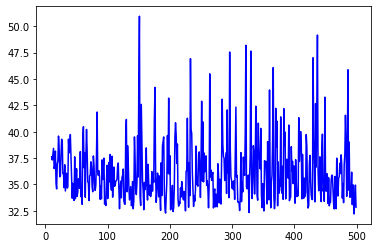

In [ ]:
loss = history.history['loss']

#A range object which will be from 10 to 100 (excluding)
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
#plt.plot(x,y)
#Take the x values to be from 10 to 100 (just like the y values)
#Take the y values to be the last 90 values of the loss (10 to 100)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()